In [1]:
import os
import numpy as np

## Section 1: Load and prepare data

In [2]:
import h5py
from arviz import hdi
from pandas import DataFrame, concat

## Extract behavior.
with h5py.File(os.path.join('stan_results',f'softmax_regression_mcmc.hdf5'), 'r') as hdf5:
    contrasts = hdf5['contrasts'][:]

## Assemble DataFrame.
data = []
for i in range(2):    
    df = DataFrame(contrasts[...,i])    # Extract contrast.    
    df['infreq'] = i                    # Insert metadata
    data.append(df)                     # Store.
    
## Concatenate and melt DataFrame.
data = concat(data).melt(id_vars='infreq', var_name='param', value_name='estimate')

## Reformat data.
data['lag'] = data['param'] % 5 + 1
data['weight'] = data.param // 5

## Compute HDIs.
credible = np.zeros(contrasts.shape[1])
for i in range(credible.size):
    lb, ub = np.sign(hdi(contrasts[:,i,-1], 0.95))
    credible[i] = int(ub - lb == 0)
credible = credible.reshape(3,5)

## Section 2: Plotting

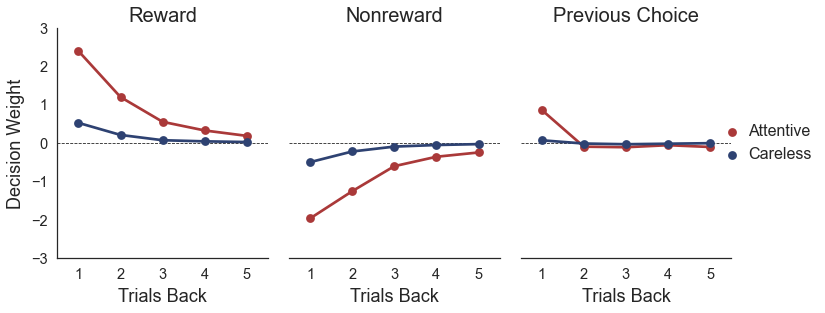

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_theme('notebook', style='white', font='sans-serif', font_scale=1.33)
%matplotlib inline

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)

## Initialize grid.
gs = fig.add_gridspec(nrows=1, ncols=3, left=0.07, right=0.85, top=0.90, bottom=0.10, wspace=0.1)

## Define aesthetic features.
titles = ['Reward', 'Nonreward', 'Previous Choice']
palette = ['#AA3939','#2E4272']
labelpad = 6

## Main loop.
for i, ax in enumerate(axes):
    
    ## Initialize axis.
    ax = plt.subplot(gs[i])
    
    ## Plot estimates.
    sns.pointplot(x='lag', y='estimate', hue='infreq', data=data.query(f'weight=={i}'), 
                  palette=palette, ci=None, ax=ax)
    ax.axhline(0, color='k', linestyle='--', lw=0.8, zorder=-1)
    
    ## Add details.
    ax.legend_.set_visible(False)
    ax.set(ylim=(-3,3), yticks=[], ylabel='')
    ax.set_xlabel('Trials Back', fontsize=18, labelpad=labelpad)
    ax.set_title(titles[i], fontsize=20)
    sns.despine(left=True, right=True, top=True, ax=ax)
    
    ## Left-most panel.
    if not i: 
        ax.set_yticks(np.arange(-3,4))
        ax.set_ylabel('Decision Weight', fontsize=18, labelpad=labelpad)
        sns.despine(right=True, top=True, ax=ax)
        
## Add legend.
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Attentive','Careless'], loc=7, bbox_to_anchor=(1.45,0.5), 
          frameon=False, fontsize=16, handletextpad=0)

## Save figure.
plt.savefig(os.path.join('..','figures','main_03c.png'), dpi=180, transparent=True)